# Utilisation du modèle SARIMA pour prédire la consommation Electrique

- Granularité : 30 minutes
- Valeur Exogène : Non

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools


FILEPATH = 'clean_data//ener_conso_full.csv'

In [2]:
conso = pd.read_csv(FILEPATH, parse_dates=[0], index_col=0, squeeze=True)
conso.index

DatetimeIndex(['2012-12-31 23:30:00+00:00', '2013-01-01 00:00:00+00:00',
               '2013-01-01 00:30:00+00:00', '2013-01-01 01:00:00+00:00',
               '2013-01-01 01:30:00+00:00', '2013-01-01 02:00:00+00:00',
               '2013-01-01 02:30:00+00:00', '2013-01-01 03:00:00+00:00',
               '2013-01-01 03:30:00+00:00', '2013-01-01 04:00:00+00:00',
               ...
               '2019-12-31 18:00:00+00:00', '2019-12-31 18:30:00+00:00',
               '2019-12-31 19:00:00+00:00', '2019-12-31 19:30:00+00:00',
               '2019-12-31 20:00:00+00:00', '2019-12-31 20:30:00+00:00',
               '2019-12-31 21:00:00+00:00', '2019-12-31 21:30:00+00:00',
               '2019-12-31 22:00:00+00:00', '2019-12-31 22:30:00+00:00'],
              dtype='datetime64[ns, UTC]', name='date_heure', length=122673, freq=None)

L'étude que nous souhaitons effectuer est sur la minute. Utiliser tout le dataframe n'est pas nécessaire et ne rendrait pas notre étude de saisonnalité lisible. 

**Nous allons étudier les 12 derniers jours :**

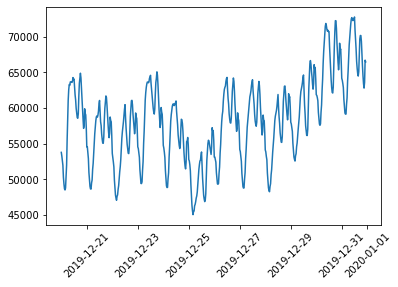

In [3]:
conso = conso['2019-12-20' : '2019-12-31']
plt.plot(conso)
plt.xticks(rotation=45)
plt.show()

Notre amplititude semble **constante**, nous pouvons supposer que nous sommes déjà dans **un modèle additif**.

Décomposons la série pour y voir plus claire sur **la tendance, la saisonnalité et le résidu**: 

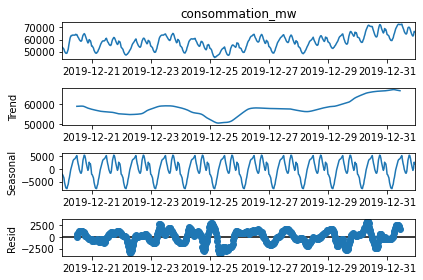

In [4]:
res = seasonal_decompose(conso, period = 48, model='additive')
res.plot()
plt.show()

Le modèle multiplicatif semble plus satisfaisant : # Bizarre, pourquoi ? Car dans le graph au dessus on dirait qu'on est additif
- La trend est légèrement **croissante**
- la saisonnalité semble difficile à estimer de la sorte
- le résidu semble être un bruit blanc comparé au modèle additif

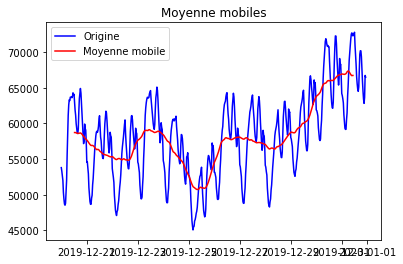

In [5]:
conso_ma = conso.rolling(window = 50, center = True).mean()

plt.plot(conso, color = 'blue', label = 'Origine')
plt.plot(conso_ma, color = 'red', label = 'Moyenne mobile')
plt.legend()
plt.title('Moyenne mobiles')
plt.show()

La tendance semble se confirmer : croissante 

Maintenant, regardons si l'autocorrélation décroit rapidement vers 0 :

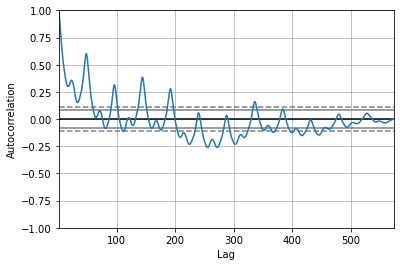

In [6]:
pd.plotting.autocorrelation_plot(conso);

La décroissance vers 0 semble encore lente. On applique donc **une différenciation d'ordre 1** sur notre série temporelle afin de voir si cela nous permet de la **stationnariser.**

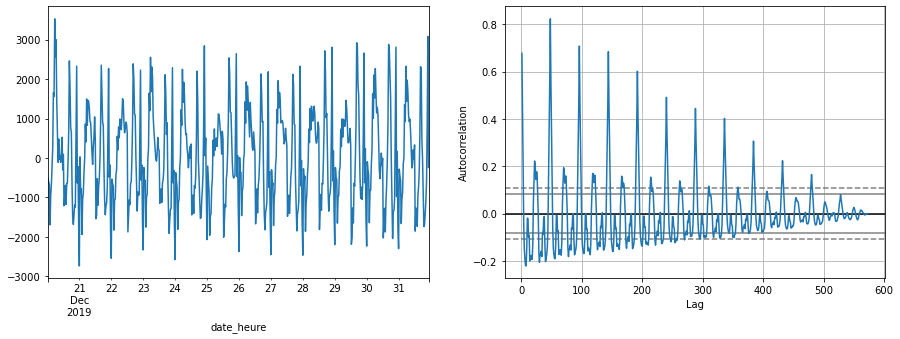

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5)) # Création de la figure et des axes

conso_1 = conso.diff().dropna() # Différenciation ordre 1

conso_1.plot(ax = ax1) #Série temporelle différenciée

pd.plotting.autocorrelation_plot(conso_1, ax = ax2); #Autocorrélogramme de la série différenciée

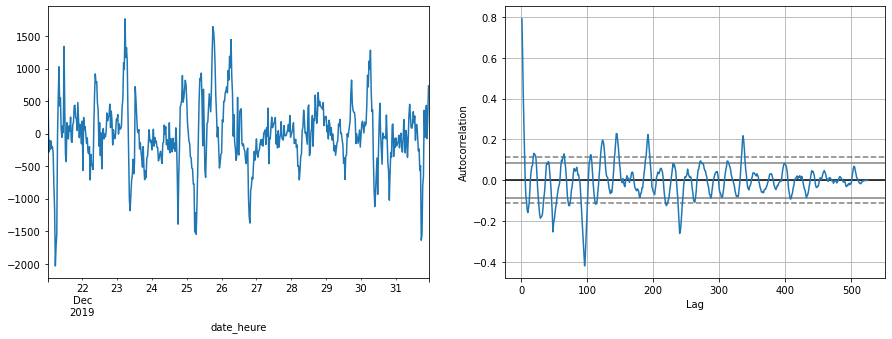

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5)) # Création de la figure et des axes

conso_2 = conso_1.diff(periods = 48).dropna() #différenciation d'ordre 48

conso_2.plot(ax = ax1) #Série temporelle différenciée doublement

pd.plotting.autocorrelation_plot(conso_2, ax = ax2); #Autocorrélogramme de la série différenciée doublement

On arrive ici à un **résultat assez satisfaisant** malgré les quelques pics irréguliers. On peut dire que les valeurs décroissent suffisamment rapidement pour qu'on puisse considérer le processus comme probablement stationnaire. Par ailleurs, la série doublement différenciée ne semble plus présenter ni de tendance ni de saisonnalité. 


**vérification avec le test d'adfuller** : 

In [9]:
_, p_value, _, _, _, _  = sm.tsa.stattools.adfuller(conso_2)
p_value  

0.0004984013117846671

**p-valeur inférieur à 1% on peut considérer la série comme stationnaire !**

nous identifions une saisonnalité de période 48 ( k=48 ). De plus nous avons fait une différenciation simple ( d=1 ) et une différenciation saisonnière ( D=1 ) pour stationnariser notre série temporelle.

Ainsi notre modèle sera de la forme  SARIMA(p,1,q)(P,1,Q)48. Il convient alors de choisir les bons ordres  p ,  q ,  P  et  Q  pour nos processus ARMA.

**Pour rappel** : 

| |AR(p)|MA(q)|ARMA(p,q)|
| --- | --- | --- | --- |
|ACF|Tends vers 0|S'annule après l'ordre q|Tends vers 0|
|PACF|S'annule après l'ordre p|Tends vers 0|Tends vers 0|

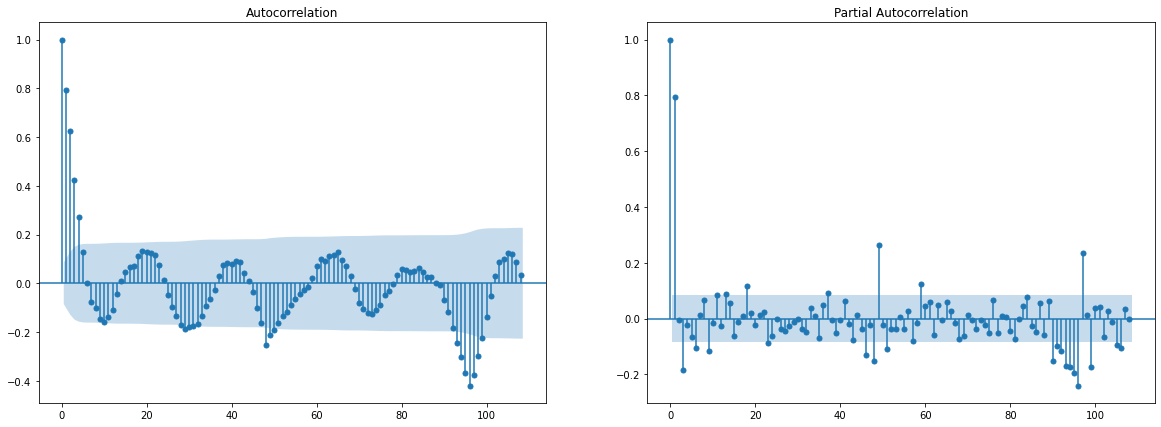

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,7))

plot_acf(conso_2, lags=108, ax=ax1)
plot_pacf(conso_2, lags=108, ax=ax2)   #96 lags car period 48
plt.show()

On remarque qu'à la fois l'autocorrélation simple et partielle tendent vers 0 (hormis les pics saisonniers). On peut donc supposer un processus  ARMA(p,q). Nous allons donc commencer par estimer via un  AR(1)AR(1)  la partie non saisonnière de notre série temporelle. [SARIMA(1,1,0)(P,1,Q)48]

Ainsi pour les ordres  p ,  q ,  P  et  Q  nous avons:

- Une décroissance de l'ACF et la PACF avec une coupure nette  : modèle  AR(1)AR(1)  , (on prend  p=1 q=0  pour débuter mais il est possible de rajouter des termes si le modèle ne semble pas suffisamment performant).

- Pour les pics saisonniers (48, 96), pas de coupure de l'ACF et une décroissance de la PACF : modèle  MA(0)MA⁡(0) 
**Nous allons donc entraîner un modèle  SARIMA(1,1,0)(0,1,0)48**

In [11]:
model = sm.tsa.SARIMAX(conso, order=(1,1,0), seasonal_order=(0,1,0,48))

sarima=model.fit()

print(sarima.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  warnings.warn('No frequency information was'


                                     SARIMAX Results                                      
Dep. Variable:                    consommation_mw   No. Observations:                  574
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 48)   Log Likelihood               -3841.743
Date:                            Fri, 19 Nov 2021   AIC                           7687.487
Time:                                    11:51:20   BIC                           7696.013
Sample:                                12-20-2019   HQIC                          7690.825
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6018      0.006    100.520      0.000       0.590       0.613
sigma2      9.083e+04   3782.782   

pas de p-value supérieur à 5% : tous les critères sont importants ici. 

Cependant les tests de bruit blanc ne semble pas avoir été passé.. (les valeurs sont à 0)

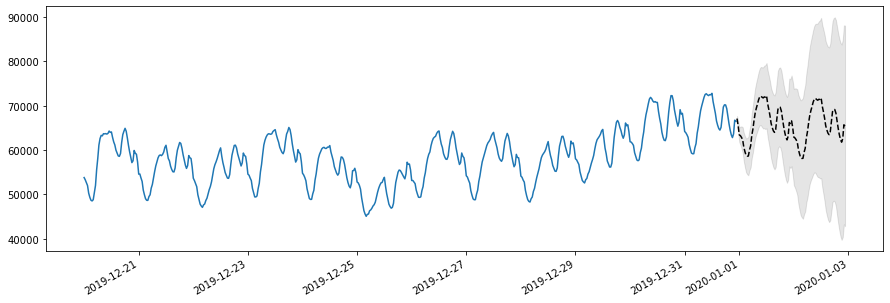

In [12]:
prediction = sarima.get_forecast(steps =96).summary_frame()  #Prédiction avec intervalle de confiance

fig, ax = plt.subplots(figsize = (15,5))

plt.plot(conso)

prediction['mean'].plot(ax = ax, style = 'k--') #Visualisation de la moyenne

ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1); #Visualisation de l'intervalle de confiance

**La prédiction pour les 48 prochains ticks semble ok mais l'intervalle de confiance s'élergit par la suite rendant notre modèle moins efficace.**

# Prédiction vs Observé sur notre sample : 

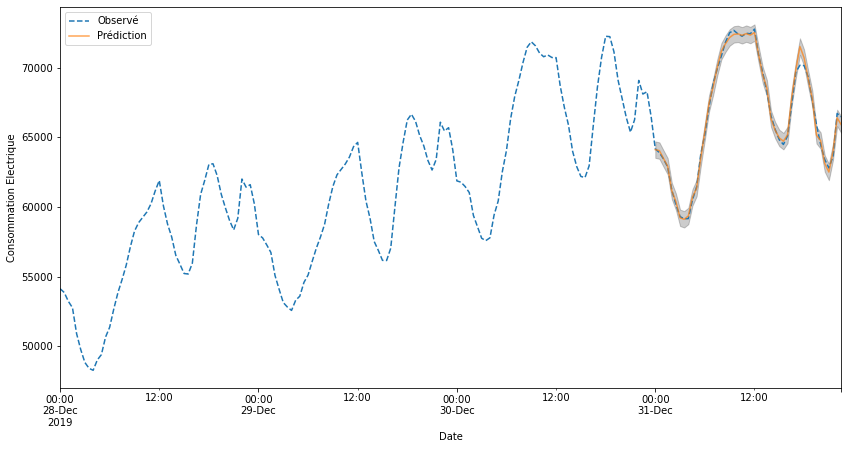

In [13]:
pred = sarima.get_prediction(start=pd.to_datetime('2019-12-31', utc=True), dynamic=False)
pred_ci = pred.conf_int()

ax = conso['2019-12-28':].plot(label='Observé', style='--')
pred.predicted_mean.plot(ax=ax, label='Prédiction', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Consommation Electrique')
plt.legend()
plt.show()

offre des prédictions plus que satisfaisante pour une journée :

### Effectuons une comparaison pour obtenir des paramètres optimaux en utilisant l'AIC.

*The Akaike Information Critera (AIC) is a widely used measure of a statistical model. It basically quantifies 1) the goodness of fit, and 2) the simplicity/parsimony, of the model into a single statistic.
When comparing two models, the one with the lower AIC is generally “better”.** 

In [14]:
import warnings
warnings.filterwarnings('ignore')

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 48) for x in list(itertools.product(p, d, q))]

params_results = {}
print("Calcul en cours...")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(conso,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            )
            results = mod.fit()
            params_results['ARIMA{}x{}48'.format(param, param_seasonal)] = round(results.aic, 0)
        except:
            continue


best_params = min(params_results, key=params_results.get)

print(best_params, 'AIC :', params_results[best_params])

Calcul en cours...
ARIMA(1, 1, 1)x(1, 1, 1, 48)48 AIC : 7521.0


# Calcul avec les paramètres ayant l'AIC le plus bas :

In [15]:
model = sm.tsa.SARIMAX(conso, order=(1,1,1), seasonal_order=(1,1,1,48))

sarima=model.fit()

print(sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                    consommation_mw   No. Observations:                  574
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 48)   Log Likelihood               -3755.287
Date:                            Fri, 19 Nov 2021   AIC                           7520.574
Time:                                    12:00:59   BIC                           7541.891
Sample:                                12-20-2019   HQIC                          7528.921
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6780      0.022     30.208      0.000       0.634       0.722
ma.L1         -0.1020      0.034   

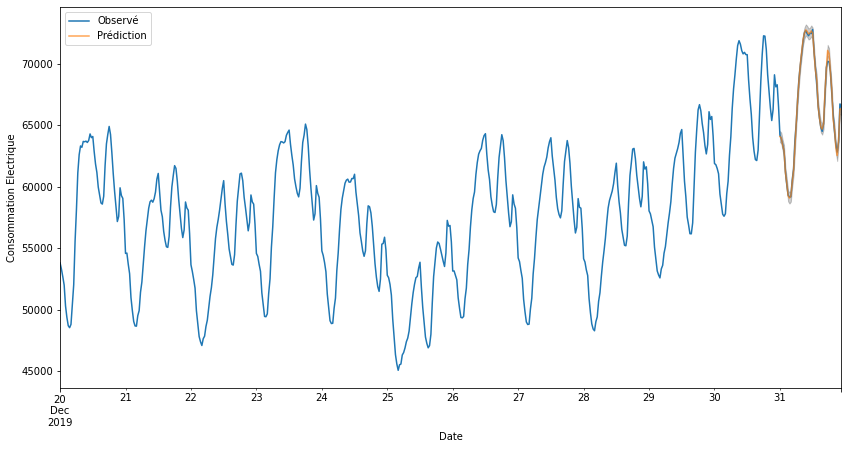

In [16]:
pred = sarima.get_prediction(start=pd.to_datetime('2019-12-31', utc=True), dynamic=False)
pred_ci = pred.conf_int()

ax = conso['2019-12-20':].plot(label='Observé')
pred.predicted_mean.plot(ax=ax, label='Prédiction', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Consommation Electrique')
plt.legend()
plt.show()